# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [1]:
from skimage import color, data, io, segmentation
from skimage.io import imread
import numpy as np
import glob
import datetime
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import jaccard_score
import tensorflow as tf
from google.colab import drive
from skimage.transform import resize

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

*   Change the path of the directories according to your drive location.

In [3]:
import os

root_path = r'/content/drive/MyDrive/Colab Notebooks/Vision/TrayDataset/'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [4]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 15

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [5]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

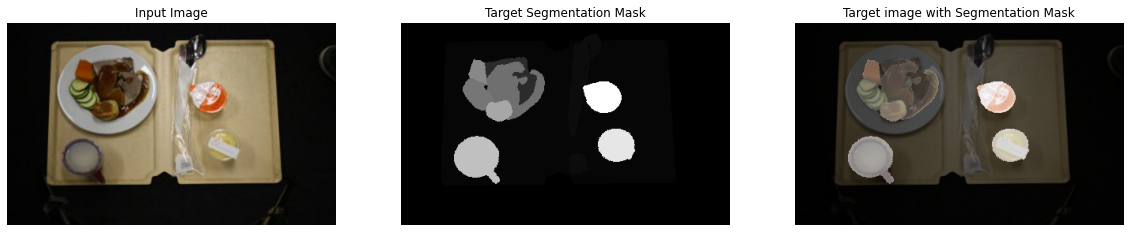

In [6]:
# solution
from PIL.ImageOps import autocontrast

f, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(load_img(train_img_paths[1]))
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(autocontrast(load_img(train_mask_paths[1])))
axes[1].set_title('Target Segmentation Mask')
axes[1].axis('off')

axes[2].imshow(load_img(train_img_paths[1]))
axes[2].imshow(autocontrast(load_img(train_mask_paths[1])), alpha=0.6)
axes[2].set_title('Target image with Segmentation Mask')
axes[2].axis('off')

plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [7]:
from tensorflow import keras


class ImageGeneator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [17]:
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [18]:
# Free up RAM 
keras.backend.clear_session()

In [19]:
# Build model
model = get_model(img_size, num_classes)

*   Print the summary of the model

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [21]:
# Instantiate data Sequences for each split
train_gen = ImageGeneator(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = ImageGeneator(8, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [22]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [23]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

*   Train the model using fit method

In [24]:
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
38/38 [==============================] - 1374s 36s/step - loss: 1.9420 - val_loss: 5.0639
Epoch 2/15
38/38 [==============================] - 9s 240ms/step - loss: 0.7593 - val_loss: 15.3482
Epoch 3/15
38/38 [==============================] - 9s 240ms/step - loss: 0.5851 - val_loss: 23.7551
Epoch 4/15
38/38 [==============================] - 9s 243ms/step - loss: 0.4932 - val_loss: 22.5900
Epoch 5/15
38/38 [==============================] - 9s 243ms/step - loss: 0.4355 - val_loss: 29.1399
Epoch 6/15
38/38 [==============================] - 10s 246ms/step - loss: 0.3654 - val_loss: 33.0191
Epoch 7/15
38/38 [==============================] - 10s 249ms/step - loss: 0.3228 - val_loss: 24.4288
Epoch 8/15
38/38 [==============================] - 10s 250ms/step - loss: 0.3000 - val_loss: 17.5960
Epoch 9/15
38/38 [==============================] - 10s 253ms/step - loss: 0.2686 - val_loss: 17.1933
Epoch 10/15
38/38 [==============================] - 10s 255ms/step - loss: 0.2555 - va

# Visualize predictions

*   Generate predictions for all images in the validation set

In [25]:
val_gen = ImageGeneator(1, img_size, test_img_paths, test_mask_paths)
val_preds = model.predict(val_gen)

8/8 [==============================] - 1s 10ms/step


*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [26]:
val_masks = np.argmax(val_preds, axis=-1)

*   Read the test mask images to create the ground truth

In [27]:
val_gt = np.array([target_batch.squeeze(0) for _, target_batch in val_gen]).squeeze(-1)

*   For each validation image, find the jaccard similarity score

In [28]:
from sklearn.metrics import jaccard_score
for pred, gt , i in zip(val_masks, val_gt, range(len(val_masks))):
    js = jaccard_score(pred.flatten(), gt.flatten(), average='micro')
    print("Jaccard similarity score for image",i,js)

Jaccard similarity score for image 0 0.8469085924536469
Jaccard similarity score for image 1 0.8677951262220925
Jaccard similarity score for image 2 0.6882645827150724
Jaccard similarity score for image 3 0.852521890151241
Jaccard similarity score for image 4 0.6736948775783728
Jaccard similarity score for image 5 0.7755583298654459
Jaccard similarity score for image 6 0.7820472660192823
Jaccard similarity score for image 7 0.8824913596587984


*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

*   This parameter specifies how the Jaccard similarity score should be averaged over the output labels, if y_true and y_pred are multiclass or multilabel.
*   The different values for the 'average' parameter and its applications' type are:

    1. **Binary:** Only report results for the class specified by pos_label. However, this is applicable only if the targets are binary.
    2. **Micro:** Compute global metrics by treating each label in the label indicator matrix as a separate label. 
    3. **Macro:** Determine the unweighted mean of the metrics for each label. Label imbalance is not taken into account in this. 
    4. **Samples:** Calculate the metrics for each instance, then average them (only meaningful for multilabel classification). 
    5. **Weighted:** Measurements for each label are calculated; their averages are then weighted by support (the number of true instances for each label). 

*   In the case of None no averaging is done, so each label's score is returned.

...

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

(-0.5, 159.5, 159.5, -0.5)

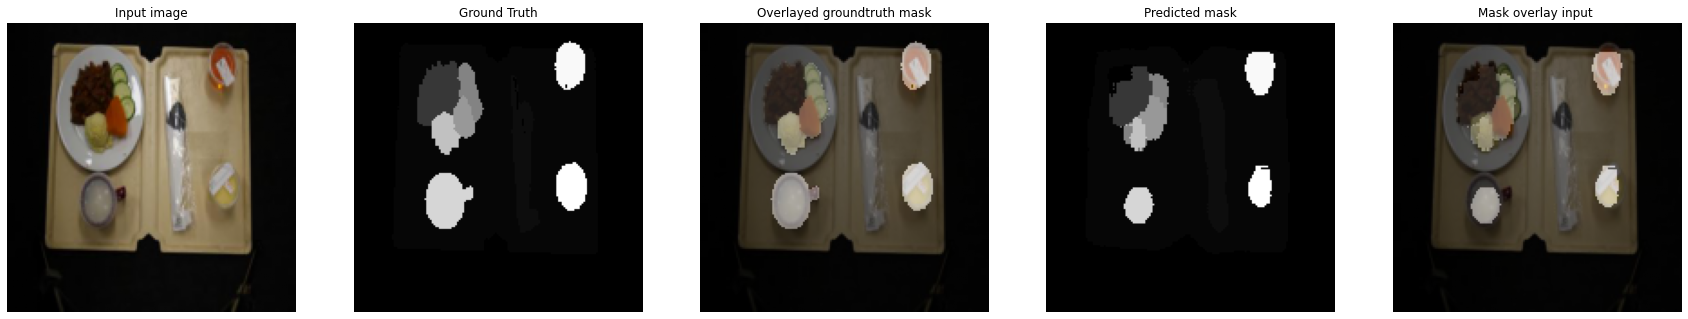

In [29]:
# solution

i = 1 #Image number to display


img = resize(imread(test_img_paths[i]), img_size)

f, axs = plt.subplots(1, 5, figsize=(30, 30))

axs[0].imshow(img)
axs[0].set_title('Input image')
axs[0].axis('off')

axs[1].imshow(val_gt[i], cmap="gray")
axs[1].set_title('Ground Truth')
axs[1].axis('off')

axs[2].imshow(img)
axs[2].set_title('Overlayed groundtruth mask')
axs[2].imshow(val_gt[i], cmap="gray", alpha=0.5)
axs[2].axis('off')

#mask = np.argmax(val_preds[i], axis=-1)
axs[3].imshow(val_masks[i], cmap="gray")
axs[3].set_title('Predicted mask')
axs[3].axis('off')


axs[4].imshow(img)
axs[4].set_title('Mask overlay input ')
axs[4].imshow(val_masks[i], cmap="gray", alpha=0.5)
axs[4].axis('off')

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

*   The other evalutation metrics to measure the performance of image segmentation algorithms are:

    1. **Average precision (AP):** This metric measures the precision of the segmentation algorithm at different recall levels. It is calculated as the area under the precision-recall curve.
    2. **Dice coefficient:** This metric calculates the amount of overlap between the segmentation that was anticipated and the actual segmentation. It is determined by dividing the total number of pixels in each segment by the ratio of pixels in the intersection of the two segmentations.
    3. **Mean pixel error:** This metric computes the average separation between the segmentation masks used for prediction and ground truth. The mean absolute difference between the two masks is used to calculate it.
    4. **Hausdorff distance:** The greatest difference between the segmentation masks of the predicted and the ground truth is measured by this statistic. The maximum distance between any two pixels in the two masks is used to calculate it.
    5. **Intersection over Union (IoU):** This metric calculates the amount of overlap between the segmentation that was anticipated and the actual segmentation. The intersection of the two segmentations to the union of the two segmentations is used to calculate it.
    6. **F1 score:** This statistic combines recall and precision to get a single score that represents the segmentation algorithm's overall performance. It is figured out as the harmonic mean of recall and precision.
    7. **Adaptive Symmetric Surfaces Distance (ASSD):** This metric calculates the separation between the segmentation masks that represent the predicted and actual data. It is determined by averaging the two masks' distances while accounting for the surfaces' regional shapes.

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [32]:
from skimage import color, data, feature, filters, io, transform 

Images_cust = []
path_cust = '/content/drive/MyDrive/Colab Notebooks/Vision/CustomFoodDataset/'
directory_files_cust = os.listdir(path_cust)

#Load the images
for image_Name in directory_files_cust:
  image = load_img(path_cust + image_Name, target_size=img_size)
  Images_cust.append(np.array(image))


1/1 [==============================] - 0s 44ms/step


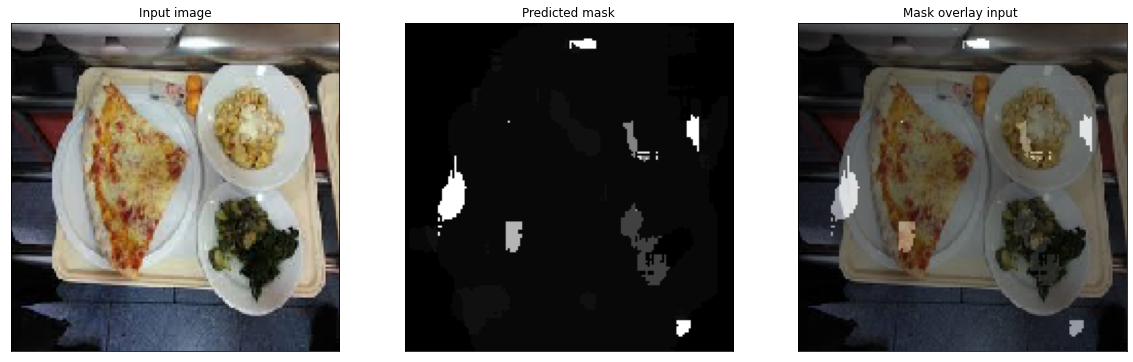

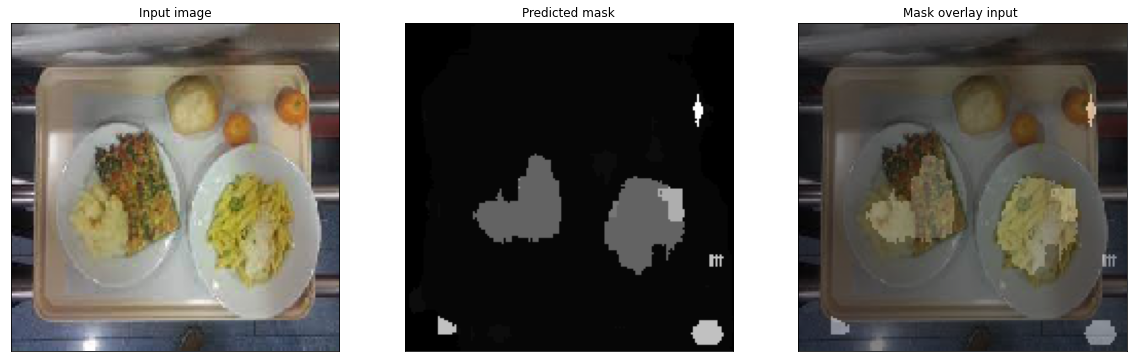

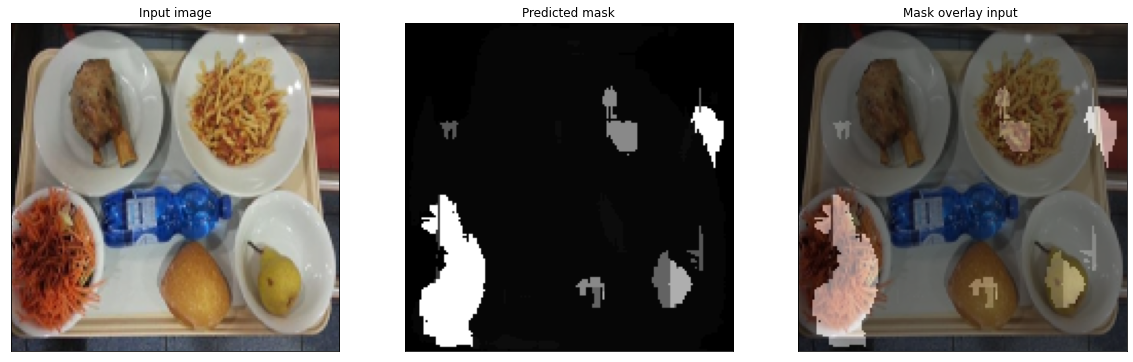

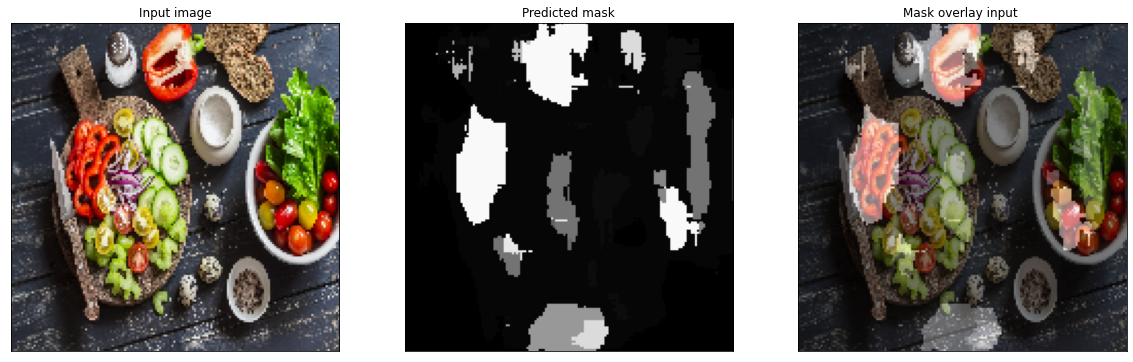

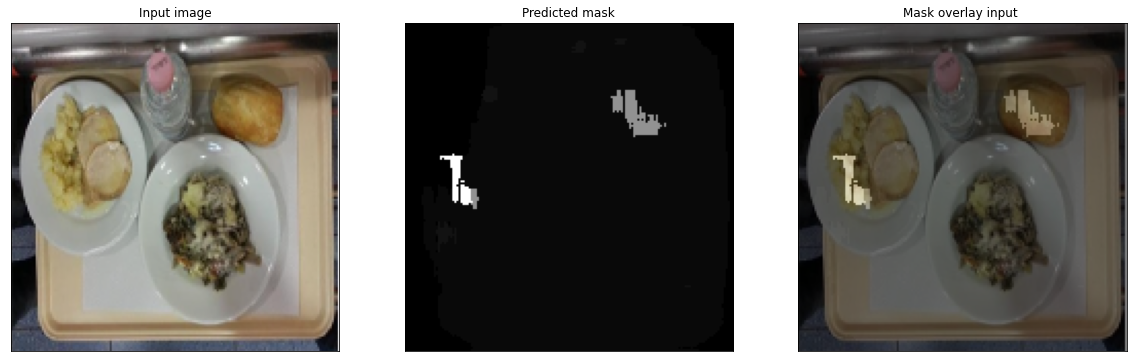

In [33]:
#make predictions
Images_cust = np.array(Images_cust)
predictions_cust = np.argmax(model.predict(Images_cust), axis=-1)

for image, predicted in zip(Images_cust, predictions_cust):
  f, axs = plt.subplots(1, 3, figsize=(20, 20))
  axs[0].imshow(image)
  axs[0].set_title('Input image')
  axs[0].set_xticks([])
  axs[0].set_yticks([])

  axs[1].imshow(predicted, cmap="gray")
  axs[1].set_title('Predicted mask')
  axs[1].set_xticks([])
  axs[1].set_yticks([])


  axs[2].imshow(image)
  axs[2].imshow(predicted, cmap="gray", alpha=0.5)
  axs[2].set_title('Mask overlay input ')
  axs[2].set_xticks([])
  axs[2].set_yticks([])

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**



*   The accuracy of the predictions of the masks are drasitcally reduced compared to the other dataset. Less portions of the food are covered by the masks, and the background is missclassified several times. Another problem is that the same food some times divided into different segments based on color variations.
*   The unlabeled classes, if similar to another class will be classified wrong, and if not, they are not classified.


 


...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

*  The problem with using a trained model in the wild is that different domains have different characteristics, making a bias. The data in the model might have a limited number of angles, illuminations, qualities of the image, and other variations compared to the wild. The real world usually also contains objects without labels, the objects can be in movement or have occlusions.

*   To make the model useful for the real world, it is important to make the model as general as possible. This can be done by using varying data augmentation techniques to deform the images with shift and rotation invariance. Other techniques are downsampling, scaling, and adding noise. Using data from different domains made by different companies can be a solution. Also applying inductive learning is a method to use information from one task to the other.

...

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

**Solution**
italicized text
*   The goal in Semantic segmentation is to give each pixel in the image a class label (such as "vehicle," "human," "tree," etc.), in which the output is a 2D map with a class name for each pixel that is the same size as the input image is the output.

[Image credits:  https://keymakr.com/blog/instance-vs-semantic-segmentation/ ]
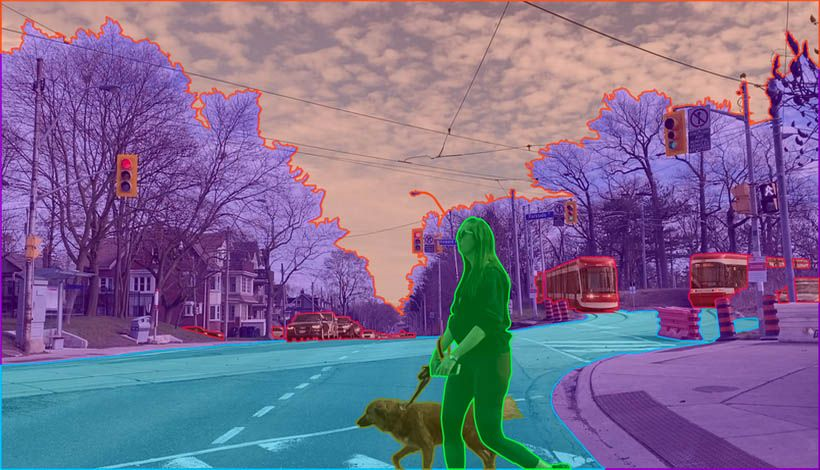

On the other hand, in instance segmentation the goal is to ecognize and separate out individual things inside an image, then give each one a distinct label, in which the output is a 2D map the same size as the input image is produced, with each pixel given a distinct label designating the object to which it belongs. 

[Image credits:  https://keymakr.com/blog/instance-vs-semantic-segmentation/ ]

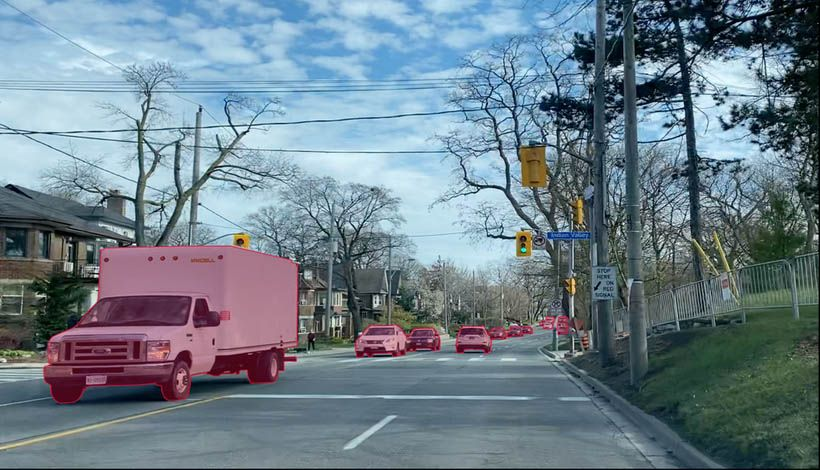

*   What is upsampling?

**Solution**

*   The process of upsampling in computer vision enlarges or raises the resolution of an image or feature map. It is frequently used in computer vision and image processing applications like image segmentation, picture restoration, and image super-resolution.

*   For example, if it is pretended to to upsample a low-resolution image with a size of 2x2 pixels to a size of 6x6 pixels. It would simply copy the values of the original 2x2 pixels to the relevant positions in the upsampled 6x6 image using closest neighbor interpolation. By taking a weighted average of the adjacent pixels in the original image, it would use bilinear interpolation to determine the values of the missing pixels in the upsampled image.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

*   In U-Net, a feature channel is a feature map that is output by one of the convolutional layers in the network. Each feature map represents the output of a convolutional kernel applied to the input image, and the channels within a feature map correspond to different filters that have been applied.

    The U-Net architecture aims to acquire rich, multi-scale characteristics that are helpful for image segmentation tasks by combining low-level and high-level features in a hierarchical fashion. The network can learn and combine features at various scales and degrees of abstraction thanks to the feature channels, which play a significant role in this process. The U-Net architecture's use of skip connections, which enables the network to directly concatenate lower-level features with higher-level characteristics, is one of its important advantages. This aids in maintaining spatial information and enables the network to produce segmentation masks using both low-level and high-level characteristics.
    
    Essentially, the feature channels in U-Net contribute significantly to the network's capacity to learn and combine features at various sizes and to its effectiveness on picture segmentation tasks.

*   What are some applications of U-Net?

**Solution**

*   Some applications of U-Net are:
    1. Brain image segmentation (BRATS)
    2. Liver image segmentation (siliver07)
    3. Protein binding site prediction
    4. Pixel-wise regression
    5. To learn Dense Volumetric Segmentation from Sparse Annotation
    6. Image-to-image translation to estimate fluorescent stains
    7. Binding site prediction of protein structure
    8. Satellite image segmentation (Raster Vision)

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

*   Besides U-Net, the other popular semantic segmentation algorithms are:
    1. Fully Convolutional Network (FCN)
    2. Mask R-CNN

*   **Fully Convolutional Networks (FCN)** is a deep learning-based approach that uses convolutional neural networks (CNNs) to perform semantic segmentation. It was one of the first deep learning-based approaches developed for this task and has been widely used in a variety of applications. FCN is designed specifically for semantic segmentation and does not have the ability to detect objects or perform object detection.
*   A variation of the well-known object detection technique R-CNN is called **Mask R-CNN** (Region-based Convolutional Neural Network). It adds a segmentation mask branch to the R-CNN architecture, allowing it to perform both object detection and semantic segmentation in a single network. This makes it a more powerful and flexible algorithm than FCN, as it can not only segment objects in an image, but also detect and classify them.
*   **U-Net** is a deep learning-based approach that uses an encoder-decoder architecture to perform semantic segmentation. Similar to FCN, U-Net is intended only for semantic segmentation and lacks any object detection or object recognition capabilities. Overall the main differences are that: 
    1. U-net is symmetric 
    2. the skip connections between the downsampling path and the upsampling path apply a concatenation operator instead of a sum.

*   In conclusion, the primary distinction between these algorithms is seen in their general design and functionality. While Mask R-CNN combines object identification and semantic segmentation, FCN and U-Net are solely semantic segmentation methods. U-Net excels at jobs requiring small, intricate objects, while Mask R-CNN is more capable and adaptable but requires more training data and computing capacity.

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

*   The popular semantic segmentation datasets avaiable are:
    1. MS COCO
    2. Cityscapes
    3. KITTI
    4. ShapeNet
    5. ScanNet
    6. NYU-Depth V2
    7. ADE20K
    8. DAVIS
    9. Synthia
    10. SUN RGB-D

    More datasets can be found at: https://paperswithcode.com/datasets?task=semantic-segmentation


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Thursday, the 22nd of December, 2022**